In [21]:
import pylab as plt
import numpy as np
from scipy import optimize, special
import cPickle
from iminuit import Minuit
import treegp
from treegp import eval_kernel
import sklearn
import warnings
import copy
%matplotlib inline

In [2]:
def get_correlation_length_matrix(size, e1, e2):
    if abs(e1)>1:
        e1 = 0
    if abs(e2)>1:
        e2 = 0
    e = np.sqrt(e1**2 + e2**2)
    q = (1-e) / (1+e)
    phi = 0.5 * np.arctan2(e2,e1)
    rot = np.array([[np.cos(phi), np.sin(phi)],
                    [-np.sin(phi), np.cos(phi)]])
    ell = np.array([[size**2, 0],
                    [0, (size * q)**2]])
    L = np.dot(rot.T, ell.dot(rot))
    return L

def gauss(x, y, sigma,
          corr_length, g1, g2, add_noise=True):
    L = get_correlation_length_matrix(corr_length, g1, g2)
    l = np.linalg.inv(L)
    dist_a = (l[0,0]*x*x) + (2*l[0,1]*x*y) + (l[1,1]*y*y)
    z = np.exp(-0.5 * dist_a)
    if add_noise:
        np.random.seed(42)
        noise = np.random.normal(scale=sigma*0.05, size=np.shape(z))
        z += noise
        return z*sigma**2, np.eye(len(z)) * (sigma*0.05)**2
    else:
        return z*sigma**2

def VK(x, y, sigma,
       corr_length, g1, g2, add_noise=True):
    L = get_correlation_length_matrix(corr_length, g1, g2)
    l = np.linalg.inv(L)
    dist_a = (l[0,0]*x*x) + (2*l[0,1]*x*y) + (l[1,1]*y*y)
    z = np.zeros_like(dist_a)
    Filter = dist_a != 0.
    z[Filter] = dist_a[Filter]**(5./12.) *  special.kv(5./6., 2*np.pi * np.sqrt(dist_a[Filter]))
    lim0 = special.gamma(5./6.) /(2 * ((np.pi)**(5./6.)) )
    if np.sum(Filter) != len(z):
        z[~Filter] = lim0
    z /= lim0
    if add_noise:
        np.random.seed(42)
        noise = np.random.normal(scale=sigma*0.05, size=np.shape(z))
        z += noise
        return z*sigma**2, np.eye(len(z)) * (sigma*0.05)**2
    else:
        return z*sigma**2
    
def model_skl(kernel_class, x, y, sigma, corr_length, g1, g2, add_noise=True):
    L = get_correlation_length_matrix(corr_length, g1, g2)
    invLam = np.linalg.inv(L)
    kernel_used = kernel(invLam=invLam)
    coord = np.array([x, y]).T
    pcf = kernel_used.__call__(coord,Y=np.zeros_like(coord))[:,0]
    if add_noise:
        np.random.seed(42)
        noise = np.random.normal(scale=sigma*0.05, size=np.shape(pcf))
        z += noise
        return pcf*sigma**2, np.eye(len(pcf)) * (sigma*0.05)**2
    else:
        return pcf*sigma**2

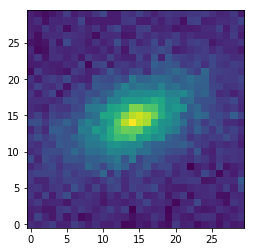

In [3]:
N = 30
x = np.linspace(-5,5,N)
x, y = np.meshgrid(x, x)
x = x.reshape(N**2)
y = y.reshape(N**2)

z, v = VK(x, y, 1., 10., 0.2, 0.2)
z = z.reshape((N,N))

plt.imshow(z, origin='lower')

FCN = 53.7323070234 
 TOTAL NCALL = 80 
 NCALLS = 80 
 
 
 EDM = 5.00724056037e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,29.7634,1.35337,,,,,No
1,x1,-0.303489,0.012868,,,,,No
2,x2,0.304975,0.0113975,,,,,No


[0.4983646556443342, 29.76343126958488, -0.30348939092049354, 0.3049745769752208, -2.99749306340097]


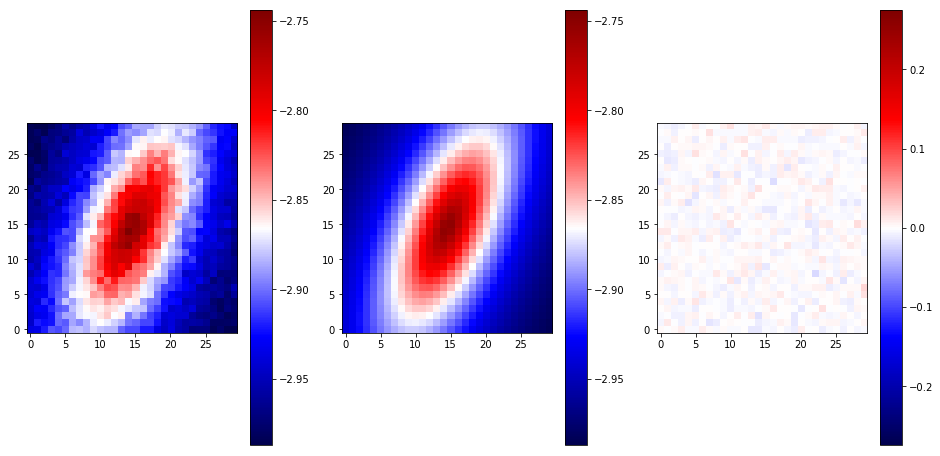

In [26]:
def get_correlation_length_matrix(size, e1, e2):
    if abs(e1)>1:
        e1 = 0
    if abs(e2)>1:
        e2 = 0
    e = np.sqrt(e1**2 + e2**2)
    q = (1-e) / (1+e)
    phi = 0.5 * np.arctan2(e2,e1)
    rot = np.array([[np.cos(phi), np.sin(phi)],
                    [-np.sin(phi), np.cos(phi)]])
    ell = np.array([[size**2, 0],
                    [0, (size * q)**2]])
    L = np.dot(rot.T, ell.dot(rot))
    return L


def get_kernel_class(A):

    if A.__class__ in [treegp.kernels.AnisotropicVonKarman, 
                       treegp.kernels.AnisotropicRBF,
                       sklearn.gaussian_process.kernels.Product]:

        if A.__class__ in [sklearn.gaussian_process.kernels.Product]:
            ok = False
            for key in A.__dict__:
                if A.__dict__[key].__class__ in [treegp.kernels.AnisotropicVonKarman,
                                                 treegp.kernels.AnisotropicRBF]:
                    kernel_class = A.__dict__[key].__class__
                    ok = True
            if not ok:
                raise ValueError('Work only with treegp.kernels.AnisotropicVonKarman and treegp.kernels.AnisotropicRBF')
        else:
            kernel_class = A.__class__
        return kernel_class
    else:
        raise ValueError('Work only with treegp.kernels.AnisotropicVonKarman and treegp.kernels.AnisotropicRBF')

class robust_2dfit(object):
    
    def __init__(self, kernel, flat_data, x, y, W, mask=None):
        
        if mask is None:
            self.mask = np.array([True]*len(x))
        else:
            self.mask = mask

        self.kernel_class = get_kernel_class(kernel)
        self.flat_data = flat_data
        self.x = x
        self.y = y
        self.coord = np.array([x, y]).T
        self.W = W
        self.N = int(np.sqrt(len(self.x)))
        
    def _model_skl(self, sigma, corr_length, g1, g2):

        L = get_correlation_length_matrix(corr_length, g1, g2)
        invLam = np.linalg.inv(L)
        kernel_used = sigma**2 * self.kernel_class(invLam=invLam)
        pcf = kernel_used.__call__(self.coord,Y=np.zeros_like(self.coord))[:,0]
        self.kernel_fit = kernel_used
        return pcf
        
    def chi2(self, param):
        model = self._model_skl(1., param[0], 
                                param[1], param[2])
        model = model[self.mask]
        F = np.array([model, np.ones_like(model)]).T
        FWF = np.dot(F.T, self.W).dot(F)
        Y = self.flat_data[self.mask].reshape((len(model), 1))
        self.alpha = np.linalg.inv(FWF).dot(np.dot(F.T, self.W).dot(Y))
        self.residuals = self.flat_data[self.mask] - ((self.alpha[0] * model) + self.alpha[1])
        self.chi2_value = self.residuals.dot(self.W).dot(self.residuals.reshape((len(model), 1)))
        return self.chi2_value

    def _minimize_minuit(self, p0 = [3000., 0.2, 0.2]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.m = Minuit.from_array_func(self.chi2, p0)
            self.m.migrad()
        results = [self.m.values[key] for key in self.m.values.keys()]
        self._minuit_result = results
        self.result = [np.sqrt(self.alpha[0][0]), results[0],
                       results[1], results[2],
                       self.alpha[1][0]]
        
        
    def minimize_minuit(self, p0 = [3000., 0.2, 0.2]):
    
        self._minimize_minuit(p0=p0)
        
        if not self.m.migrad_ok():
            N_restart = 3
            g1 = np.linspace(-0.3, 0.3, N_restart)
            size = np.linspace(p0[0] - p0[0]/10., 2*p0[0], N_restart) 
            g1, g2, size = np.meshgrid(g1, g1, size)
            N_restart = int(N_restart**3)
            g1 = g1.reshape(N_restart)
            g2 = g2.reshape(N_restart)
            size = size.reshape(N_restart)
            for i in range(N_restart):
                print "restart fit because failure"
                new_p0 = [size[i], g1[i], g2[i]]
                print new_p0
                self._minimize_minuit(p0=new_p0)
                if self.m.migrad_ok():
                    break
        pcf = self._model_skl(self.result[0], self.result[1], 
                              self.result[2], self.result[3])
        
    def plot_result(self):
        CMAP = plt.cm.seismic
        MAX = np.max(self.flat_data)
        MIN = np.min(self.flat_data)
        print self.result
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        plt.imshow(self.flat_data.reshape((self.N,self.N)), 
                   origin="lower", vmin=MIN, 
                   vmax=MAX, cmap=CMAP)
        plt.colorbar()
        
        plt.subplot(1,3,2)
        predict = self._model_skl(self.result[0], self.result[1], 
                                  self.result[2], self.result[3]) + self.result[4]
        plt.imshow(predict.reshape((self.N,self.N)), 
                   origin="lower", vmin=MIN, 
                   vmax=MAX, cmap=CMAP)
        plt.colorbar()
        
        plt.subplot(1,3,3)
        residuals = self.flat_data - predict
        plt.imshow(residuals.reshape((self.N,self.N)), 
                   origin="lower", vmin=-MAX/10., 
                   vmax=MAX/10., cmap=CMAP)
        plt.colorbar()

N = 30
x = np.linspace(-5,5,N)
x, y = np.meshgrid(x, x)
x = x.reshape(N**2)
y = y.reshape(N**2)

z, v = VK(x, y, 0.5, 30., -0.3, 0.3)
z -= 3
w = np.linalg.inv(v)

A = eval_kernel("2 * AnisotropicVonKarman(invLam=np.array([[1., 0], [0., 1.]]))")

fg = robust_2dfit(A, z, x, y, w)
#fg.minimize(p0 = [0.2, -0., -0.])
fg.minimize_minuit(p0 = [25., 0.2, 0.2])
fg.plot_result()

In [35]:
dic = cPickle.load(open('../../astrometry/17946_z_copy/gp_output_17946.pkl'))

FCN = 340.006024837 
 TOTAL NCALL = 168 
 NCALLS = 168 
 
 
 EDM = 4.93908745657e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,30978.3,3790.63,,,,,No
1,x1,-0.381143,0.0138998,,,,,No
2,x2,0.250312,0.0106497,,,,,No


[4.554474889511751, 30978.265270705488, -0.38114319103777333, 0.2503117600903036, -16.57753149697014]


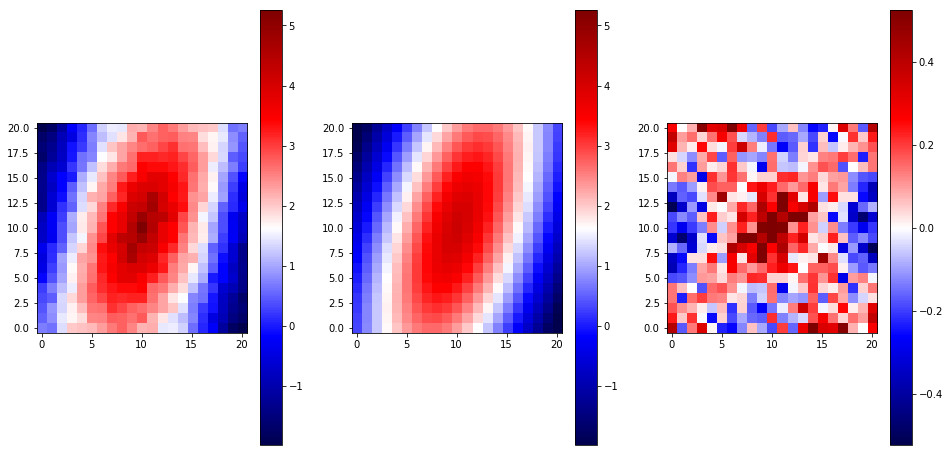

In [36]:
z = dic['gp_output']['gpu.2pcf']
x = dic['gp_output']['gpu.2pcf_dist'][:,0]
y = dic['gp_output']['gpu.2pcf_dist'][:,1]
w = dic['gp_output']['gpu.2pcf_weight']
mask = dic['gp_output']['gpu.2pcf_mask']

A = eval_kernel("2 * AnisotropicVonKarman(invLam=np.array([[1., 0], [0., 1.]]))")
#fg = fit_gauss(x, y, z, w, mask=mask)
fg = robust_2dfit(A, z, x, y, w, mask=mask)
fg.minimize_minuit(p0 = [500., 0.2, 0.2])
fg.plot_result()
#fg.m.migrad_ok()

In [32]:
np.dot(fg.flat_data*fg.coord.T, fg.coord) #/ np.sum(fg.flat_data**2)

array([[-23525.66812411,    151.38834491],
       [   151.38834491, -23343.8293698 ]])

In [37]:
get_correlation_length_matrix(3., 0.2, 0.2)

array([[8.09389194, 2.18753836],
       [2.18753836, 3.71881522]])

In [33]:
def moment(coord, data):
    sum_data = np.sum(data)
    Mxx = np.sum(data * coord[:,0]**2) / sum_data
    Myy = np.sum(data * coord[:,0]**2) / sum_data
    Mxy = np.sum(data * coord[:,0] * coord[:,1]) / sum_data
    
    return np.array([[Mxx, Mxy], [Mxy, Myy]])

In [38]:
moment(fg.coord, fg.flat_data)

array([[ 9.01925301, -0.03214927],
       [-0.03214927,  9.01925301]])

In [24]:
fg.kernel_fit = copy.deepcopy(4 * fg.kernel_fit)

In [27]:
fg.kernel_fit

0.498**2 * AnisotropicVonKarman(invLam=array([[ 0.00623199, -0.00212109],
       [-0.00212109,  0.00201046]]))

In [29]:
Minuit?